# Import Packages

In [1]:
import torchvision
print(torchvision.__version__)

0.20.1+cu124


### For part 1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time 

### For part 2

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

### Check for GPU


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset

In [7]:
train_dataset = STL10(root="/storage/dmls/stl10_data", split="train", download=False, transform=transform)
test_dataset = STL10(root="/storage/dmls/stl10_data", split="test", download=False, transform=transform)

train_dataset_200 = torch.utils.data.Subset(train_dataset, range(200))


## DataLoaders

In [7]:
train_loader = DataLoader(train_dataset_200, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Show Samples

In [8]:
def show_samples(dataset, num_samples=4):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Change to HxWxC format for display
        image = (image * 0.5 + 0.5).numpy()  # Unnormalize
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

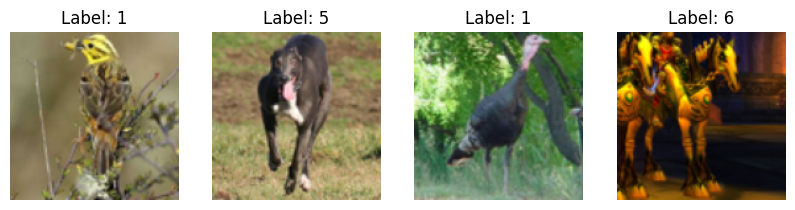

In [9]:
show_samples(train_dataset_200, num_samples=4)

# Part 1

## RGB TO GRAY function

In [10]:
def rgb2grey_py(image):
    height = image.size(1)
    width = image.size(2)
    gray_image = torch.zeros((height, width))

    for i in range(height):
        for j in range(width):
            r = image[0][i][j]
            g = image[1][i][j]
            b = image[2][i][j]
            gray_value = 0.2989 * r + 0.5870 * g + 0.1140 * b
            gray_image[i][j] = gray_value

    return gray_image

### Convert all images in the first 200 samples to grayscale

In [11]:
grayscale_images_part1 = []
start_time_python = time.time()
for i, (image, label) in enumerate(train_dataset_200):
    image = image.to(device)  # Send to the same device as tensor operations
    gray_image = rgb2grey_py(image)
    grayscale_images_part1.append((gray_image, label))

end_time_python = time.time()
python_time = end_time_python - start_time_python
print(f"Time taken for Python-based grayscale conversion: {python_time:.4f} seconds")

Time taken for Python-based grayscale conversion: 205.1622 seconds


### Plot the first 4 grayscale images

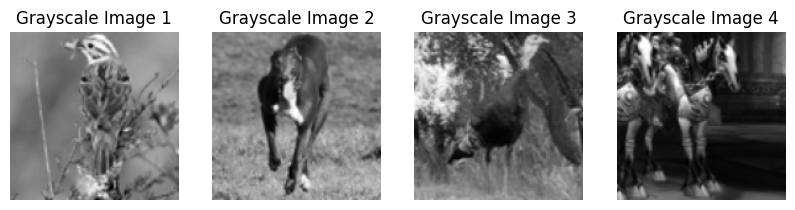

In [12]:
plt.figure(figsize=(10, 5))
for i in range(4):
    original_image, label = train_dataset_200[i]
    original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC
    original_image = (original_image * 0.5 + 0.5)  # Unnormalize

    gray_image, label = grayscale_images_part1[i]
    gray_image = gray_image.cpu().numpy()

    plt.subplot(1, 4, i + 1)
    plt.imshow(gray_image, cmap="gray")
    plt.title(f"Grayscale Image {i + 1}")
    plt.axis("off")

plt.show()

# Part 2

In [15]:
%pip install -q wurlitzer ninja
%load_ext wurlitzer

Note: you may need to restart the kernel to use updated packages.


### environment variable

In [16]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Function to load CUDA kernel

In [17]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O3"] if opt else [], verbose=verbose, name="inline_ext")

## # CUDA and C++ source code


In [ ]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;  
    if (i < n) {
        out[i] = 0.299f * x[i] + 0.587f * x[i + n] + 0.114f * x[i + 2 * n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);  
    int h = input.size(1);  
    int w = input.size(2);  
    int num_pixels = h * w;  

    auto output = torch::empty({h, w}, input.options());

    int threads = 256;

    rgb_to_grayscale_kernel<<<(num_pixels + threads - 1) / threads, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), num_pixels);

    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [56]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

### Compile and load the CUDA kernel

In [57]:
module = load_cuda(cuda_src, cpp_src, funcs=["rgb_to_grayscale"])

/home/dmls/pytorch/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


### Check for GPU

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [59]:
grayscale_images_part2 = []

start_time_python = time.time()
for i, (image, label) in enumerate(train_dataset_200):
    image = image.to(device)  # Send to the same device as tensor operations
    
    # Un-normalize the image from [-1, 1] to [0, 255]
    image = (image + 1) * 127.5  # Convert from [-1, 1] to [0, 255]
    image = image.clamp(0, 255)  # Ensure values are in the valid range [0, 255]
    
    # Convert to uint8 and move to GPU (for CUDA kernel)
    image_uint8 = image.to(torch.uint8).contiguous().to(device)
    
    # Call the CUDA kernel for grayscale conversion
    gray_image = module.rgb_to_grayscale(image_uint8)  # Pass the uint8 image to the kernel
    
    # Append the grayscale image and label
    grayscale_images_part2.append((gray_image, label))

end_time_python = time.time()
CUDA_time = end_time_python - start_time_python
print(f"Time taken for CUDA-based grayscale conversion: {CUDA_time:.4f} seconds")

Time taken for CUDA-based grayscale conversion: 0.1801 seconds


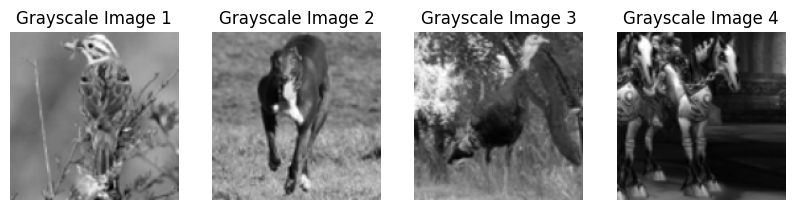

In [60]:
plt.figure(figsize=(10, 5))
for i in range(4):
    original_image, label = train_dataset_200[i]
    original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC
    original_image = (original_image * 0.5 + 0.5)  # Unnormalize

    gray_image, label = grayscale_images_part2[i]
    gray_image = gray_image.cpu().numpy()

    plt.subplot(1, 4, i + 1)
    plt.imshow(gray_image, cmap="gray")
    plt.title(f"Grayscale Image {i + 1}")
    plt.axis("off")

plt.show()


# Part 3

## Python Function

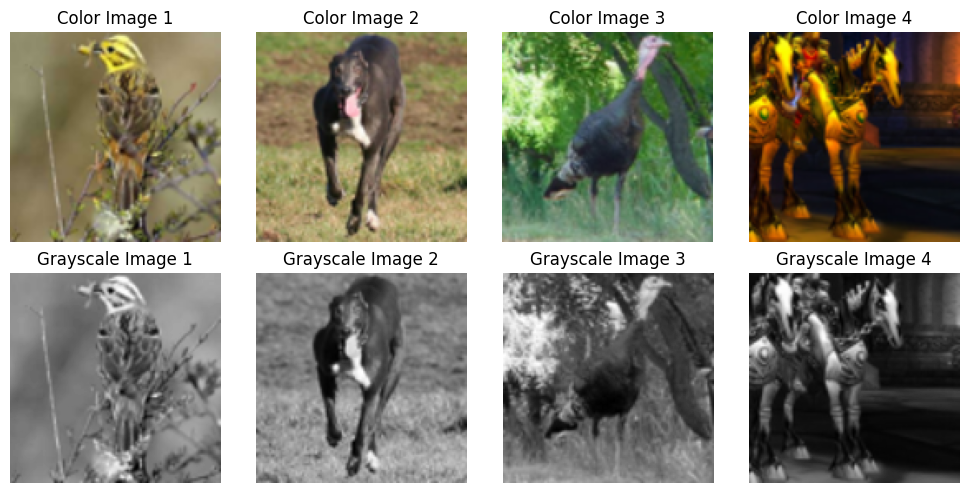

Time taken for Python-based grayscale conversion: 205.1622 seconds


In [14]:
plt.figure(figsize=(10, 5))

for i in range(4): 
    original_image, label = train_dataset_200[i]
    original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC
    original_image = (original_image * 0.5 + 0.5)  # Unnormalize to display the original image

    gray_image, label = grayscale_images_part1[i]
    gray_image = gray_image.cpu().numpy()

    plt.subplot(2, 4, i + 1)
    plt.imshow(original_image)
    plt.title(f"Color Image {i + 1}")
    plt.axis("off")

    plt.subplot(2, 4, i + 5) 
    plt.imshow(gray_image, cmap="gray")
    plt.title(f"Grayscale Image {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(f"Time taken for Python-based grayscale conversion: {python_time:.4f} seconds")

## CUDA

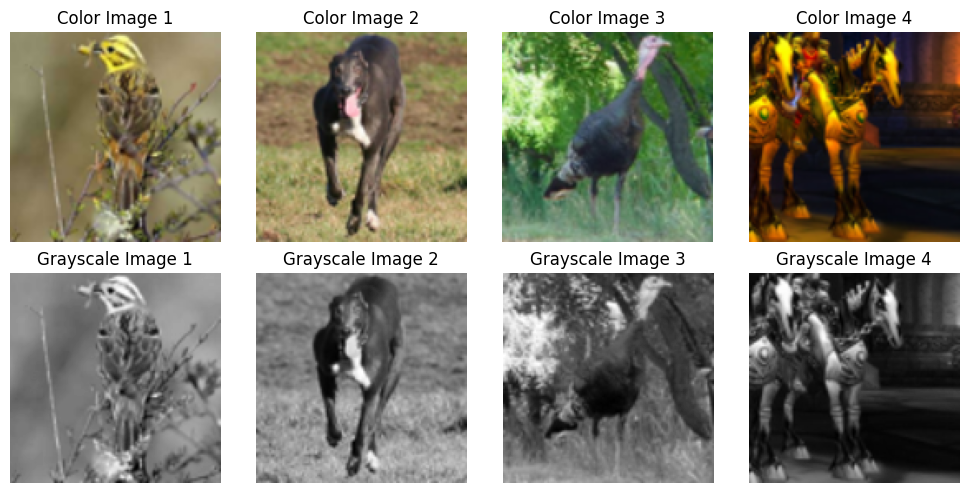

Time taken for CUDA-based grayscale conversion: 0.1801 seconds


In [62]:
plt.figure(figsize=(10, 5))

for i in range(4): 
    original_image, label = train_dataset_200[i]
    original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC
    original_image = (original_image * 0.5 + 0.5)  # Unnormalize to display the original image

    gray_image, label = grayscale_images_part2[i]
    gray_image = gray_image.cpu().numpy()

    plt.subplot(2, 4, i + 1)
    plt.imshow(original_image)
    plt.title(f"Color Image {i + 1}")
    plt.axis("off")

    plt.subplot(2, 4, i + 5) 
    plt.imshow(gray_image, cmap="gray")
    plt.title(f"Grayscale Image {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(f"Time taken for CUDA-based grayscale conversion: {CUDA_time:.4f} seconds")